# Clustering with the Artificial Immune Network - AiNet

## 1. Introduction

Clustering is an unsupervised machine learning task that aims to group a dataset into the same group (called a cluster).

In this notebook, we will explore **AiNet (Artificial Immune Network)**. AiNet uses concepts such as antibody affinity and clone suppression to identify cluster centers in the data.

**Objective:** The goal is to demonstrate the effectiveness of AiNet in clustering random datasets:
* **Blobs:** Well-defined, spherical clusters.
* **Moons:** Clusters with a non-linear shape.
* **Circles:** Clusters arranged in two concentric circles, showing non-linear separation. 

**Notebook Structure:**
- **Setup:** Installation and import of necessary libraries.
- **Visualization Function:** Definition of a function to plot the results.
- **Demonstration 1 - Blobs Dataset:** Applying AiNet to blobs.
- **Demonstration 2 - Moons Dataset:** Applying AiNet to moons.
- **Demonstration 3 - Circles Dataset:** Applying AiNet to circles.


## 2. Setup

### Installation of the necessary libraries.

In [ ]:
%pip install scikit-learn
%pip install matplotlib
%pip install networkx
%pip install aisp

### Importing the necessary libraries

In [1]:
# Importing the Artificial Immune Network (AiNet)
from aisp.ina import AiNet

# Libraries for data manipulation and numerical calculations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Generation of synthetic datasets for clustering
from sklearn.datasets import make_blobs, make_moons, make_circles

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx

# Functions for calculating minimum spanning trees and distances
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import squareform, pdist


## 3. Visualization Function

In [2]:
def plot_immune_network(train_x, predict_y, model, title_prefix=""):
    """
    Plots the clustering results of AiNet.

    Parameters:
        train_x (np.array): Input data.
        predict_y (np.array): Cluster predictions from the model.
        model (AiNet): The trained AiNet model.
        title_prefix (str, optional): A prefix for the plot titles.
    """
    clusters = list(model._memory_network.values())
    network = np.array(model._population_antibodies)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    colors = colormaps.get_cmap('Accent')

    # Original data
    axs[0][0].scatter(train_x[:, 0], train_x[:, 1], color='dodgerblue', alpha=0.9, s=50, marker='o', edgecolors='k')
    axs[0][0].set_title(f'{title_prefix}Original Data', fontsize=16)
    axs[0][0].set_xlabel('X', fontsize=14)
    axs[0][0].set_ylabel('Y', fontsize=14)
    axs[0][0].grid(True, linestyle='--', alpha=0.5)

    # Antibody population
    axs[0][1].scatter(network[:, 0], network[:, 1], color='crimson', alpha=0.9, s=70, marker='.', edgecolors='k')
    axs[0][1].set_title(f'{title_prefix}Antibody Population', fontsize=16)
    axs[0][1].set_xlabel('X', fontsize=14)
    axs[0][1].set_ylabel('Y', fontsize=14)
    axs[0][1].grid(True, linestyle='--', alpha=0.5)

    # Cluster predictions
    scatter = axs[1][0].scatter(train_x[:, 0], train_x[:, 1], c=predict_y, cmap='Accent', s=50, edgecolors='k', alpha=0.9)
    axs[1][0].set_title(f'{title_prefix}Cluster Predictions (AiNet)', fontsize=16)
    axs[1][0].set_xlabel('X', fontsize=14)
    axs[1][0].set_ylabel('Y', fontsize=14)
    axs[1][0].grid(True, linestyle='--', alpha=0.5)
    legend1 = axs[1][0].legend(*scatter.legend_elements(), title="Clusters")
    axs[1][0].add_artist(legend1)

    # Immune Network Graph
    G = nx.Graph()
    positions = {}
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        G.add_nodes_from(cluster_nodes)
        for node, point in zip(cluster_nodes, cluster):
            positions[node] = tuple(point)
        dist_matrix = squareform(pdist(cluster))
        mst_local = minimum_spanning_tree(dist_matrix).toarray()
        for row_idx, row in enumerate(mst_local):
            for col_idx, weight in enumerate(row):
                if weight > 0:
                    G.add_edge(cluster_nodes[row_idx], cluster_nodes[col_idx], weight=weight)
    for i, cluster in enumerate(clusters):
        cluster_nodes = [f'{i}_{j}' for j in range(len(cluster))]
        nx.draw_networkx_nodes(G, positions, nodelist=cluster_nodes, ax=axs[1][1],
                               node_color=[colors(i)], node_size=70, edgecolors='k', label=f'Cluster {i}')
    nx.draw_networkx_edges(G, positions, ax=axs[1][1], alpha=0.6)
    axs[1][1].set_title(f'{title_prefix}Graph Immune Network', fontsize=16)
    axs[1][1].set_xlabel('X', fontsize=14)
    axs[1][1].set_ylabel('Y', fontsize=14)
    axs[1][1].grid(True, linestyle='--', alpha=0.5)
    axs[1][1].legend()
    plt.tight_layout()
    plt.show()

## 4. Demonstration 1 - Blobs Dataset

### 4.1 Generating random data blobs for the classes

Using the `make_blobs` function, two datasets in the form of blobs are generated within the range 0 to 1, representing each class x and y. These data are then split into training and test sets.

In [3]:
# Generating samples and outputs for training.
samples, output = make_blobs(
    n_samples=1000,
    cluster_std=0.07,
    center_box=(0.0, 1.0),
    centers=[[0.25, 0.75], [0.75, 0.25]],
    random_state=1234,
)

### 4.2 Training the AiNet model on the blobs data

The model will identify patterns, form clusters, and classify the samples.

In [4]:

model = AiNet(suppression_threshold=0.96, affinity_threshold=0.95, mst_inconsistency_factor=3, seed=123)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 104:  ┇██████████┇ 10/10 total training interactions


#### 4.3 Evaluating the clustering quality with the silhouette coefficient

In [5]:
silhouette = silhouette_score(samples, predict_y)
print(f"Silhouette Coefficient: {silhouette:.3f}")

Silhouette Coefficient: 0.826


### 4.4 Visualizing AiNet results for the blobs data

Displays four plots: the original data, the antibody population, the clusters predicted by AiNet, and the graph of the formed immune network.

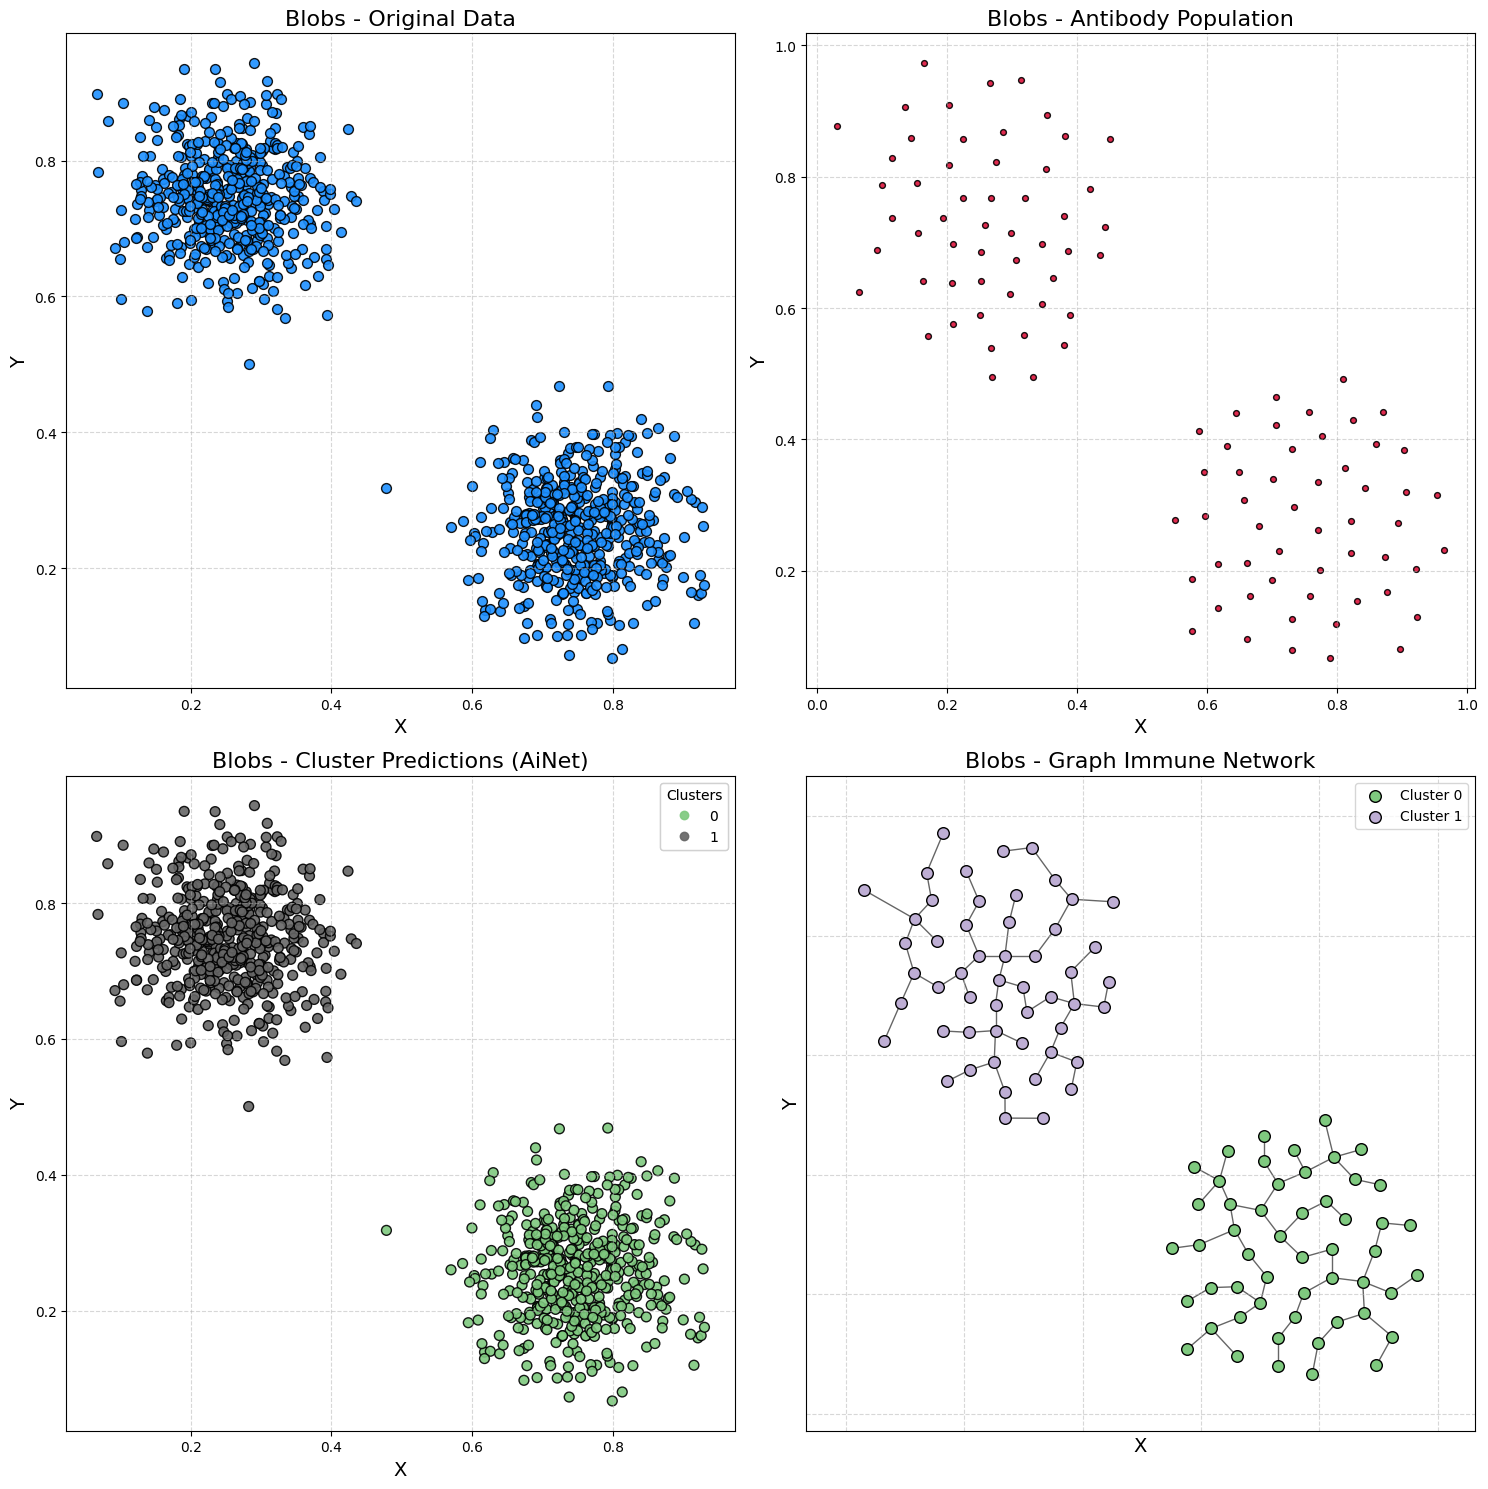

In [6]:
plot_immune_network(samples, predict_y, model, title_prefix="Blobs - ")

## 5. Demonstration 2 - Moons Dataset

### 5.1 Generating "moons" shaped data

Generates a dataset in the shape of two intertwined moons.

In [7]:
# Generating samples and outputs for training.
samples, output = make_moons(n_samples=1000, noise=0.05, random_state=42)
samples = MinMaxScaler().fit_transform(samples)

### 5.2 Training AiNet on the "moons" data

The model will identify patterns, form clusters, and classify the samples.

In [8]:
model = AiNet(suppression_threshold=0.95, affinity_threshold=0.97, mst_inconsistency_factor=2.5, seed=123)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 69:  ┇██████████┇ 10/10 total training interactions


#### 5.3 Evaluating the clustering quality with the silhouette coefficient

In [9]:
silhouette = silhouette_score(samples, predict_y)
print(f"Silhouette Coefficient: {silhouette:.3f}")

Silhouette Coefficient: 0.398


#### 5.4 Visualizing AiNet on the "moons" data

Displays four plots: the original data, the antibody population, the clusters predicted by AiNet, and the graph of the formed immune network.

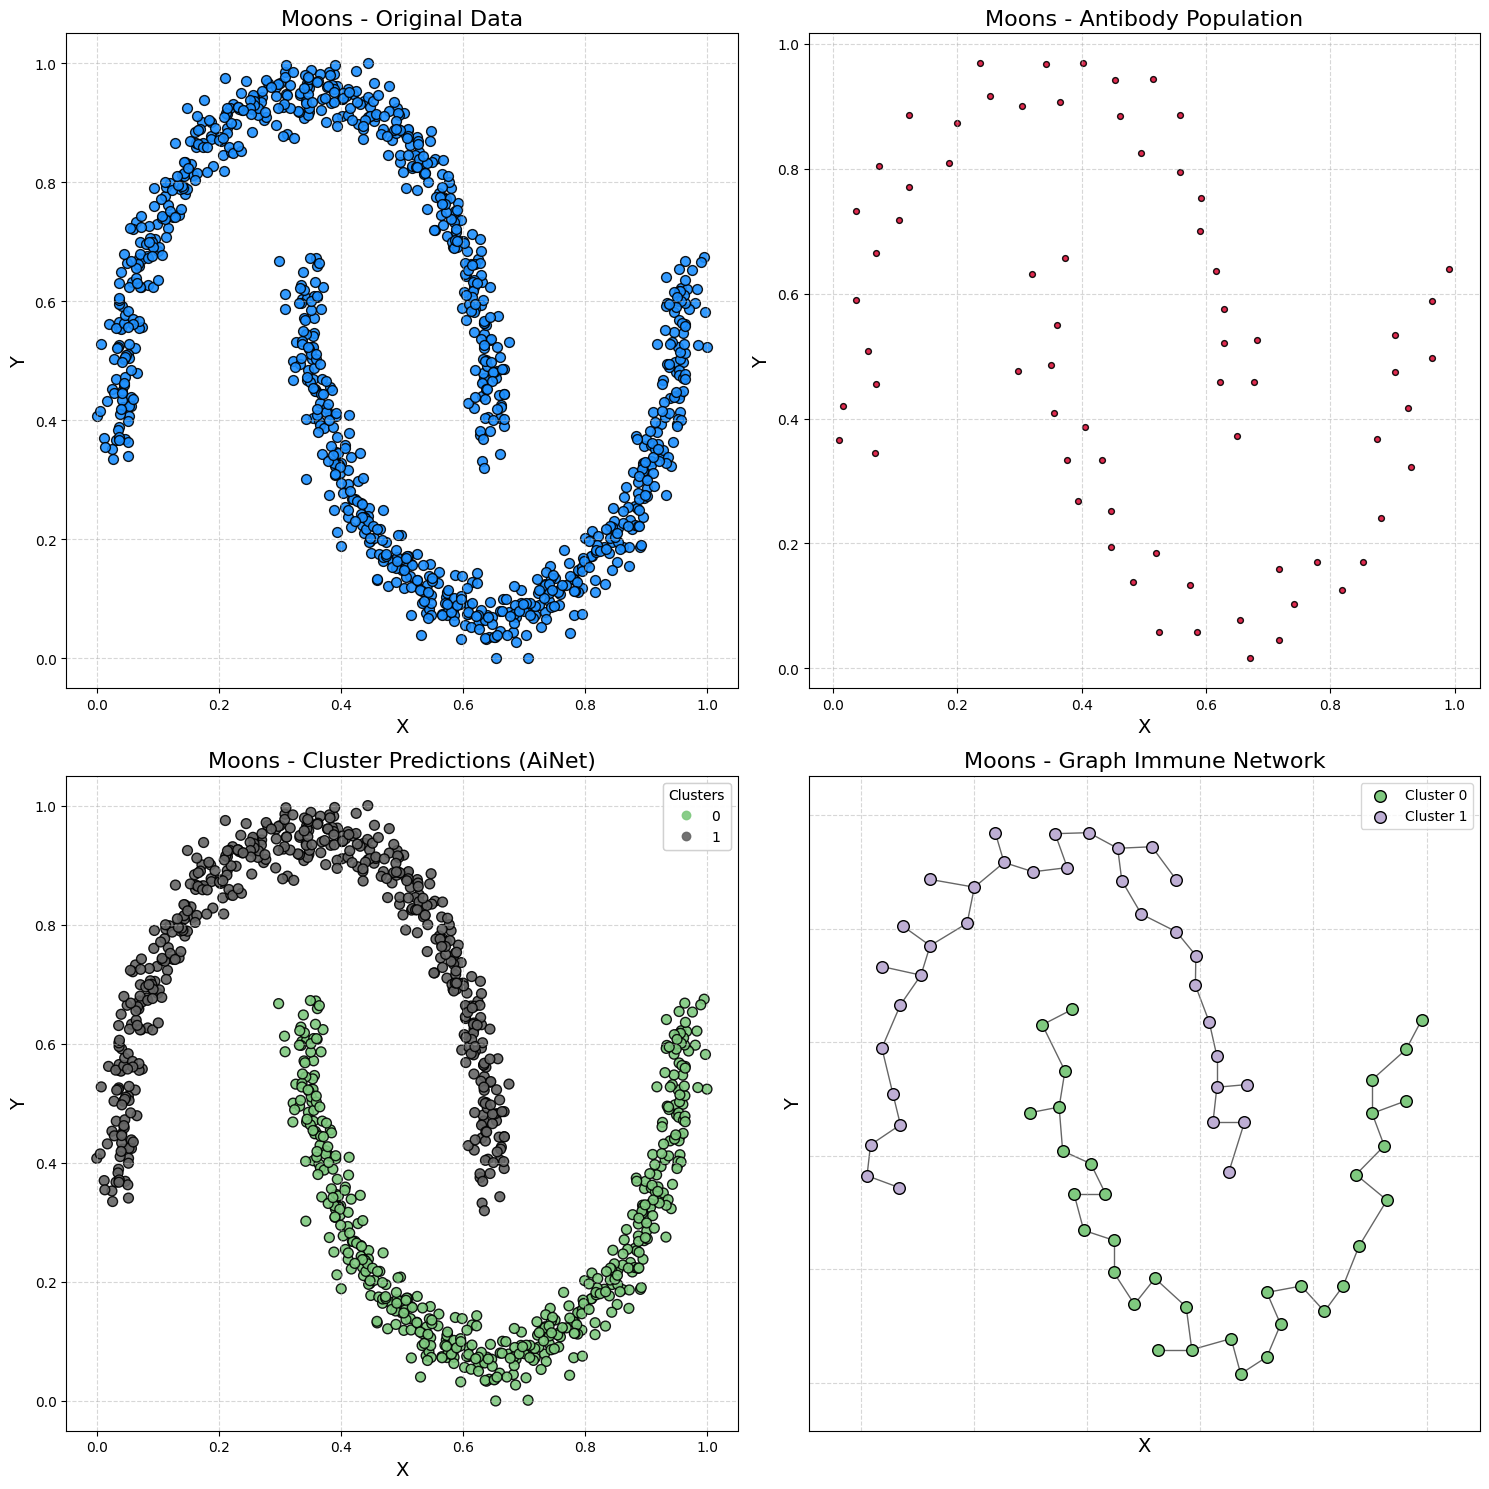

In [10]:
plot_immune_network(samples, predict_y, model, title_prefix="Moons - ")

## 6. Demonstration 3 - Circles Dataset

### 6.1 Generating concentric circles data

Using `make_circles` to create data in two circles.

In [11]:
# Generating samples and outputs for training.
samples, output = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)
samples = MinMaxScaler().fit_transform(samples)

#### 6.2 Training AiNet on the "circles" data

The model will identify patterns, form clusters, and classify the samples.

In [12]:
model = AiNet(suppression_threshold=0.97, affinity_threshold=0.98, mst_inconsistency_factor=3.8, seed=123)

predict_y = model.fit_predict(samples)

✔ Set of memory antibodies for classes (0, 1) successfully generated | Clusters: 2 | Population of antibodies size: 169:  ┇██████████┇ 10/10 total training interactions


#### 6.3 Evaluating the clustering quality with the silhouette coefficient

In [13]:
silhouette = silhouette_score(samples, predict_y)
print(f"Silhouette Coefficient: {silhouette:.3f}")

Silhouette Coefficient: 0.112


#### 6.4 Visualizing AiNet on the circles data

Displays four plots: the original data, the antibody population, the clusters predicted by AiNet, and the graph of the formed immune network.

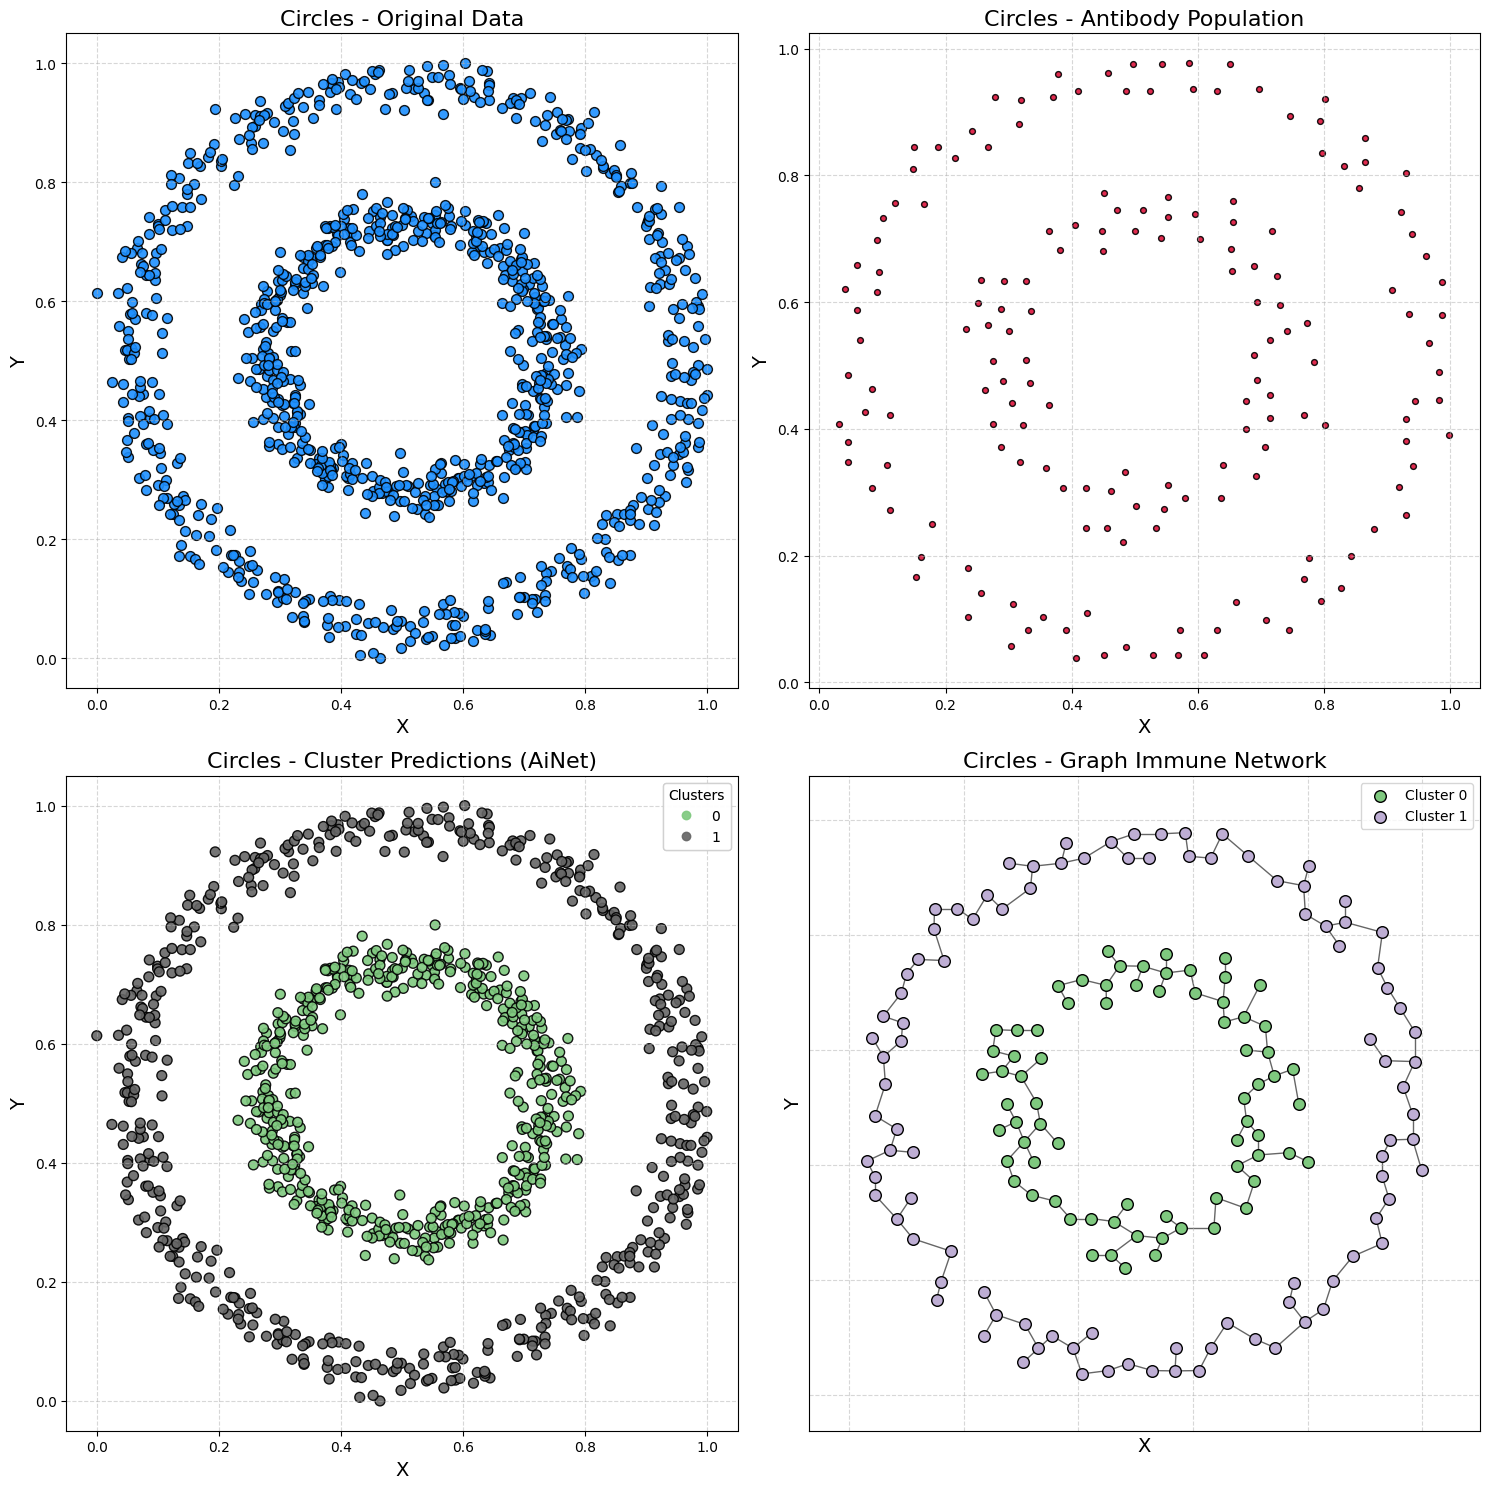

In [14]:
plot_immune_network(samples, predict_y, model, title_prefix="Circles - ")